# Titanic model building

In [1]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
from loadDataUtils import loadDataUtils

In [3]:
path_train = r'C:\Users\39320\Desktop\myProjects_python\Titanic\data\train.csv'
path_test = r'C:\Users\39320\Desktop\myProjects_python\Titanic\data\test.csv'
data = loadDataUtils(path_train, path_test)

In [4]:
df_train, df_test = data.get_train_and_test()

### Clean data

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
from titanicPreprocessing import preprocess

In [7]:
p = preprocess(df_train.copy(), df_test.copy())
p.do_preprocess()

In [8]:
train, test = p.get_data()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          889 non-null    int64  
 1   Survived             889 non-null    int64  
 2   Pclass               889 non-null    int64  
 3   Age                  889 non-null    float64
 4   SibSp                889 non-null    int64  
 5   Parch                889 non-null    int64  
 6   Fare                 889 non-null    float64
 7   cabin_multiple       889 non-null    int64  
 8   Sex_female           889 non-null    uint8  
 9   Sex_male             889 non-null    uint8  
 10  Embarked_C           889 non-null    uint8  
 11  Embarked_Q           889 non-null    uint8  
 12  Embarked_S           889 non-null    uint8  
 13  cabin_letter_0       889 non-null    uint8  
 14  cabin_letter_A       889 non-null    uint8  
 15  cabin_letter_B       889 non-null    uin

In [10]:
train_target = train['Survived']
train.drop(columns=['Survived'], inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, train_target, test_size=0.3, random_state=42)

## Model building

In [12]:
from sklearn.model_selection import cross_val_score

#### Baseline

the gender submission provided by kaggle could be our baseline. In fact, this dataset is characterized by the fact that they assumed that all women would have survived, so we expect an accuracy of about 50%.

In [13]:
import pandas as pd
baseline = pd.read_csv(r'C:\Users\39320\Desktop\myProjects_python\Titanic\data\gender_submission.csv')

In [14]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [15]:
from sklearn.metrics import accuracy_score

baseline_acc = accuracy_score(baseline['Survived'], y_train[0:418])
baseline_acc

0.49760765550239233

we put the value of 418 in the y_train to make a comparison. When we divided the dataset our trainset had more than 418 observations, so we put the limit

#### Gaussian Naive Bayes (GaussianNB)

In [16]:
from sklearn.naive_bayes import GaussianNB

#I usually use Naive Bayes as a baseline for my classification tasks
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.688      0.688      0.75806452 0.71774194 0.75      ]
0.7203612903225807


#### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
"""
lr = LogisticRegression(max_iter = 20000)
cv = cross_val_score(lr,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())
"""

[0.832      0.856      0.83064516 0.84677419 0.78225806]
0.8295354838709678


In [18]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=10)
print(cv)
print(cv.mean())

[0.87301587 0.77777778 0.83870968 0.85483871 0.87096774 0.79032258
 0.87096774 0.80645161 0.79032258 0.79032258]
0.8263696876600102


we can already observe that with the logistic regression we get almost 10% more accuracy than the GaussianNB

#### Deciosion tree

In [215]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.712      0.8        0.79032258 0.80645161 0.81451613]
0.7846580645161291


In [231]:
dt.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
dt.score(X_test.loc[:, X_test.columns != 'PassengerId'],y_test)

0.7640449438202247

In [218]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("Titanic_decision_tree")

'titanic.pdf'

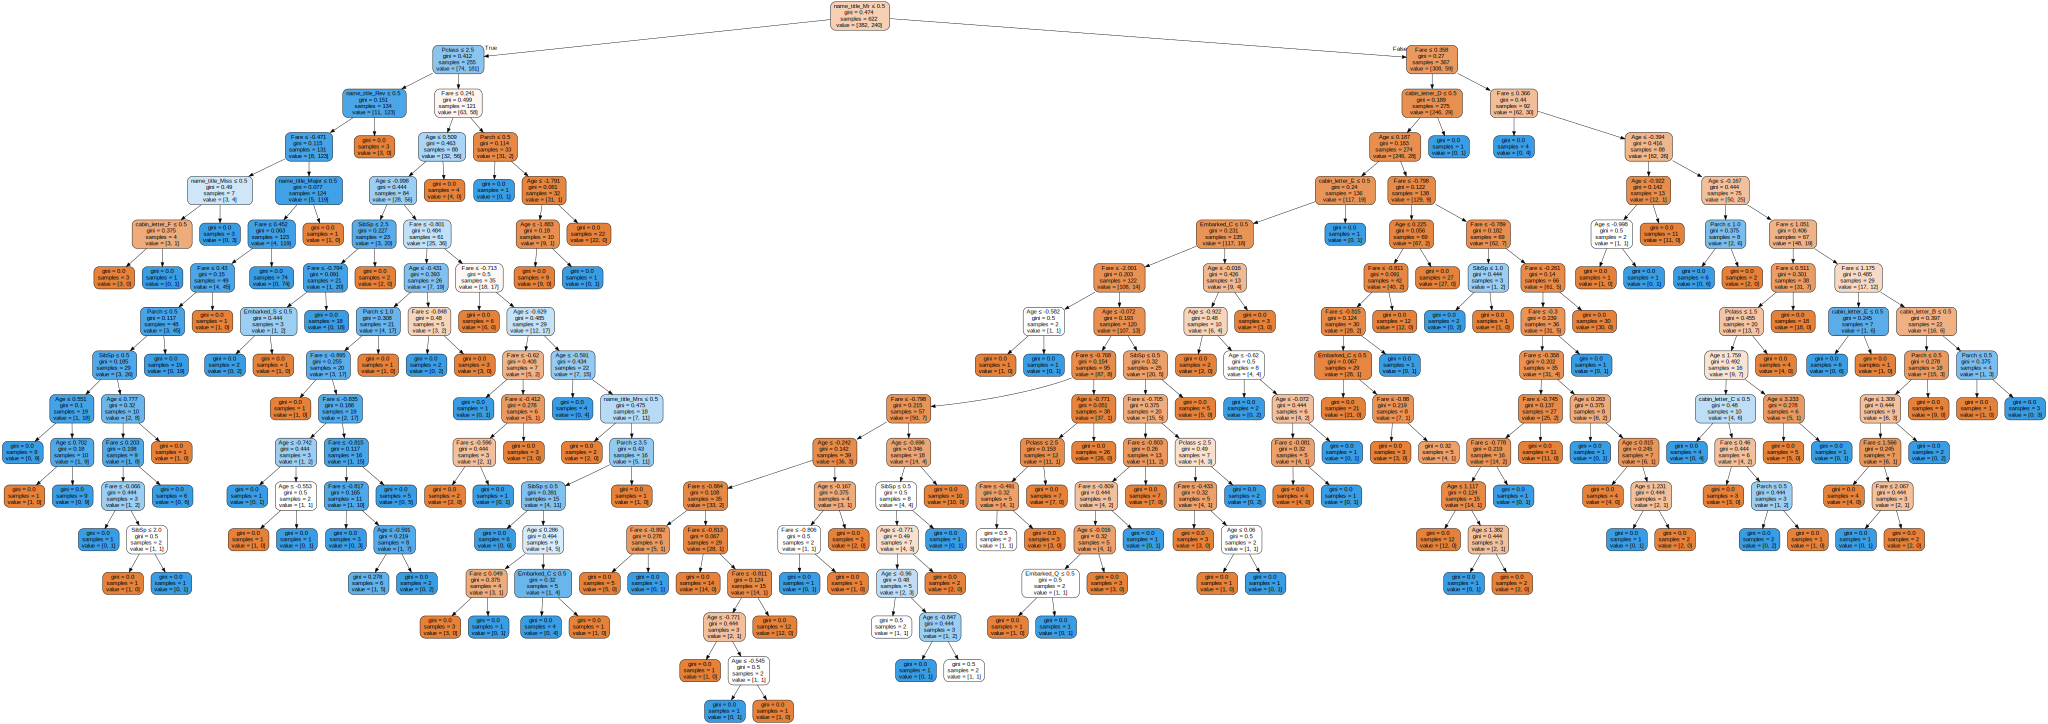

In [223]:
dot_data = tree.export_graphviz(dt, out_file=None,
                      feature_names=X_train.loc[:, X_train.columns != 'PassengerId'].columns,
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

As we can see, the complexity of the tree is very large. Perhaps this is also why it is not good at modeling data and making good predictions.

#### K Nearest Neighbor

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.856      0.848      0.84677419 0.83870968 0.83870968]
0.8456387096774194


I wasn't expecting good accuracies like this. In fact, I believed that the algorithm would have made it difficult to define which were the closest points. In fact, having a 38-dimensional space, I didn't think it was easy to define the distance between points in space.

#### Random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state = 1)
cv = cross_val_score(rf,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.832      0.856      0.86290323 0.83870968 0.7983871 ]
0.8376000000000001


In [235]:
from sklearn.metrics import accuracy_score

In [236]:
rf.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)

y_pred = rf.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(y_pred, y_test)

0.7827715355805244

#### Support vector machine

In [22]:
from sklearn.svm import SVC

svc = SVC(probability=True)
cv = cross_val_score(svc,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.84       0.872      0.81451613 0.83870968 0.83064516]
0.8391741935483872


In [23]:
from sklearn.metrics import accuracy_score

svc.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)

y_pred = svc.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(y_pred, y_test)

0.8127340823970037

#### XGboost

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
cv = cross_val_score(xgb,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.792      0.808      0.87096774 0.84677419 0.81451613]
0.8264516129032259


#### Voting classifier

In [25]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svm',svc),('xgb',xgb)], voting = 'soft')

In [26]:
cv = cross_val_score(voting_clf,X_train.loc[:, X_train.columns != 'PassengerId'],y_train,cv=5)
print(cv)
print(cv.mean())

[0.88       0.848      0.87096774 0.83870968 0.82258065]
0.8520516129032257


This method consists in having the various models vote. I expected it to be the best because different models can and are able to capture information other than data. I compensate each other for the shortcomings.

In [232]:
voting_clf.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
p_v = voting_clf.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(p_v, y_test)

0.8014981273408239

If we try it with the test data, perhaps we see that this voting model goes into overfitting a bit.

#### GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

from utils import clf_performance

In [28]:
param_grid_lr = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

param_grid_knn = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}

param_grid_svc = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]

param_grid_rf =  {'n_estimators': [100,500,1000],
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}

param_grid_xgb = {
    'n_estimators': [20, 50, 100, 250, 500,1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,.01,.1,1,10,100],
    'min_child_weight':[0,.01,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}

In [29]:
lr_g = LogisticRegression()
knn_g = KNeighborsClassifier()
svc_g = SVC(probability = True)
rf_g = RandomForestClassifier(random_state = 1)
xgb_g = XGBClassifier(random_state = 1)

In [30]:
clf_lr = GridSearchCV(lr_g, param_grid = param_grid_lr, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8359741935483871
Best Parameters: {'C': 11.288378916846883, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [31]:
clf_knn = GridSearchCV(knn_g, param_grid = param_grid_knn, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8552645161290323
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [238]:
knn_best = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 5, p= 1, weights= 'uniform')
knn_best.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)

y_pred_best_knn = knn_best.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(y_pred_best_knn, y_test)

0.7752808988764045

In [32]:
clf_svc = GridSearchCV(svc_g, param_grid = param_grid_svc, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8456516129032258
Best Parameters: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}


In [237]:
svc_best = SVC(C= 1, gamma= 0.5, kernel= 'rbf')
svc_best.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)

y_pred_best = svc_best.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(y_pred_best, y_test)

0.797752808988764

In [33]:
clf_rf_rnd = RandomizedSearchCV(rf_g, param_distributions = param_grid_rf, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest
Best Score: 0.8681290322580646
Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


In [34]:
clf_rf = GridSearchCV(rf_g, param_grid = param_grid_rf, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Random Forest
Best Score: 0.8697419354838709
Best Parameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


In [234]:
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(bootstrap= False, max_depth= 50, max_features= 'auto', min_samples_leaf= 2, min_samples_split= 10, n_estimators= 500)
rf_best.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
pred_rf_best = rf_best.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(pred_rf_best, y_test)

0.797752808988764

In [35]:
clf_xgb_rnd = RandomizedSearchCV(xgb_g, param_distributions = param_grid_xgb, n_iter = 1000, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_xgb_rnd,'XGB')

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\39320\Desktop\myProjects_python\Titanic\venvimg\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2525 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\39320\Desktop\myProjects_python\Titanic\venvimg\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\39320\Desktop\myProjects_python\Titanic\venvimg\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\39320\Desktop\myProjects_python\Titanic\venvimg\lib\site-packages\xgboost\sklear

XGB
Best Score: 0.868141935483871
Best Parameters: {'subsample': 0.9, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 20, 'min_child_weight': 0.01, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.8}


C:\Users\39320\Desktop\myProjects_python\Titanic\venvimg\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.85209032 0.83272258        nan 0.82157419        nan
        nan        nan 0.78451613 0.77965161 0.61414194        nan
 0.61414194        nan 0.82473548        nan        nan 0.61414194
 0.61414194        nan        nan 0.82313548        nan        nan
        nan 0.61414194        nan        nan        nan        nan
        nan 0.61414194 0.81509677 0.80708387        nan        nan
        nan 0.82482581        nan        nan        nan        nan
 0.79576774        nan        nan 0.61414194        nan 0.81509677
        nan 0.61414194        nan        nan        nan 0.61414194
        nan 0.81188387        nan        nan        nan        nan
        nan        nan 0.8295871  0.75256774        nan        nan
 0.61414194        nan 0.78294194        nan        nan 0.81673548
 0.75064516 0.6141419

In [239]:
xgb_best = XGBClassifier(subsample= 0.9, sampling_method= 'uniform', reg_lambda= 2, reg_alpha= 0.5, n_estimators= 20, min_child_weight= 0.01, max_depth= 15, learning_rate= 0.3, gamma= 0.1, colsample_bytree= 0.8)
xgb_best.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)

y_pred_best_xgb = xgb_best.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(y_pred_best_xgb, y_test)

0.8127340823970037

In [36]:
"""clf_xgb = GridSearchCV(xgb_g, param_grid = param_grid_xgb, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_xgb,'XGB')"""

"clf_xgb = GridSearchCV(xgb_g, param_grid = param_grid_xgb, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_xgb = clf_xgb.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)\nclf_performance(best_clf_xgb,'XGB')"

In [37]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb_rnd.best_estimator_

In [38]:
voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard')
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft')
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft')
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

In [39]:
print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())

voting_clf_hard : [0.72       0.688      0.74193548 0.68548387 0.72580645]
voting_clf_hard mean : 0.7122451612903224
voting_clf_soft : [0.808      0.816      0.78225806 0.75       0.79032258]
voting_clf_soft mean : 0.7845032258064515
voting_clf_all : [0.824      0.856      0.83870968 0.82258065 0.7983871 ]
voting_clf_all mean : 0.8295483870967741
voting_clf_xgb : [0.84       0.856      0.84677419 0.84677419 0.83064516]
voting_clf_xgb mean : 0.8456516129032258


In [40]:
params_voting = {'weights' : [[1,1,1,1,1],[1,1,1,1,2],[1,1,1,2,2],[1,1,2,2,2],[1,2,2,2,2],
                              [3,4,2,3,1]]}

In [41]:
vote_weight = GridSearchCV(voting_clf_xgb, param_grid = params_voting, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test.loc[:, X_test.columns != 'PassengerId'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
VC Weights
Best Score: 0.8584903225806452
Best Parameters: {'weights': [3, 4, 2, 3, 1]}


In [240]:
voting_clf_best = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft', weights=[3,4,2,3,1])
voting_clf_best.fit(X_train.loc[:, X_train.columns != 'PassengerId'],y_train)
p_v_best = voting_clf_best.predict(X_test.loc[:, X_test.columns != 'PassengerId'])
accuracy_score(p_v_best, y_test)

0.797752808988764

The weights chosen as the best are the ones I entered by hand. In fact, looking at the performance of the various models from the cells above, I gave a greater weight to the best models and a lesser weight to the models that had earlier had lower accuracy.

##### At the end the best model is the xgb

### Deep learning

In this section I try to implement some simple neural networks in keras. I don't expect good performance because neural networks are too complex for this task and will likely overfit the model right away. In any case it is necessary to do some tests.

In [200]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [201]:
keras_classifier = Sequential()

In [202]:
keras_classifier.add(Dense(16, input_dim=X_train.shape[1]-1, kernel_initializer='uniform', activation='relu'))
keras_classifier.add(Dense(8, kernel_initializer='uniform', activation='relu'))
keras_classifier.add(Dense(4, kernel_initializer='uniform', activation='relu'))
keras_classifier.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
keras_classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [203]:
keras_classifier.fit(X_train.loc[:, X_train.columns != 'PassengerId'], y_train, epochs = 5)

Epoch 1/5
20/20 [==============================] - 1s 2ms/step - loss: 0.6920 - accuracy: 0.6093
Epoch 2/5
20/20 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.6141
Epoch 3/5
20/20 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.6141
Epoch 4/5
20/20 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.6141
Epoch 5/5
20/20 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.6141


In [204]:
#keras_prediction = keras_classifier.predict(X_test)

In [205]:
#k_pred = np.rint(keras_prediction)

In [206]:
#accuracy_score(k_pred, y_test)

In [213]:
keras_classifier.evaluate(X_test.loc[:, X_test.columns != 'PassengerId'], y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.6255


[0.6479284167289734, 0.6254681944847107]

#### keras 2

In [209]:
keras_classifier2 = Sequential()

keras_classifier2.add(Dense(16, input_dim=X_train.shape[1]-1, kernel_initializer='uniform', activation='relu'))
keras_classifier2.add(Dense(6, kernel_initializer='uniform', activation='relu'))
keras_classifier2.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
keras_classifier2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

keras_classifier2.fit(X_train.loc[:, X_train.columns != 'PassengerId'], y_train, epochs =25)

Epoch 1/25
20/20 [==============================] - 0s 891us/step - loss: 0.6922 - accuracy: 0.6029
Epoch 2/25
20/20 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.6141
Epoch 3/25
20/20 [==============================] - 0s 682us/step - loss: 0.6862 - accuracy: 0.6141
Epoch 4/25
20/20 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.6141
Epoch 5/25
20/20 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6576
Epoch 6/25
20/20 [==============================] - 0s 2ms/step - loss: 0.6226 - accuracy: 0.7251
Epoch 7/25
20/20 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.7894
Epoch 8/25
20/20 [==============================] - 0s 1ms/step - loss: 0.5200 - accuracy: 0.7990
Epoch 9/25
20/20 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.7958
Epoch 10/25
20/20 [==============================] - 0s 617us/step - loss: 0.4529 - accuracy: 0.8006
Epoch 11/25
2

In [210]:
keras_classifier2.evaluate(X_test.loc[:, X_test.columns != 'PassengerId'], y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.8052


[0.4467730224132538, 0.8052434325218201]

#### keras 3

In [211]:
keras_classifier3 = Sequential()

keras_classifier3.add(Dense(10, input_dim=X_train.shape[1]-1, kernel_initializer='uniform', activation='relu'))
keras_classifier3.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
opt = keras.optimizers.Adam(learning_rate=0.01)
keras_classifier3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

keras_classifier3.fit(X_train.loc[:, X_train.columns != 'PassengerId'], y_train, epochs =25)

Epoch 1/25
20/20 [==============================] - 0s 1ms/step - loss: 0.6459 - accuracy: 0.7588
Epoch 2/25
20/20 [==============================] - 0s 828us/step - loss: 0.4896 - accuracy: 0.7958
Epoch 3/25
20/20 [==============================] - 0s 830us/step - loss: 0.4192 - accuracy: 0.8071
Epoch 4/25
20/20 [==============================] - 0s 1ms/step - loss: 0.4062 - accuracy: 0.8312
Epoch 5/25
20/20 [==============================] - 0s 553us/step - loss: 0.4000 - accuracy: 0.8280
Epoch 6/25
20/20 [==============================] - 0s 2ms/step - loss: 0.3991 - accuracy: 0.8360
Epoch 7/25
20/20 [==============================] - 0s 823us/step - loss: 0.3957 - accuracy: 0.8312
Epoch 8/25
20/20 [==============================] - 0s 1ms/step - loss: 0.3936 - accuracy: 0.8344
Epoch 9/25
20/20 [==============================] - 0s 570us/step - loss: 0.3959 - accuracy: 0.8408
Epoch 10/25
20/20 [==============================] - 0s 1ms/step - loss: 0.3872 - accuracy: 0.8441
Epoch 11/

In [212]:
keras_classifier3.evaluate(X_test.loc[:, X_test.columns != 'PassengerId'], y_test)

9/9 [==============================] - 0s 0s/step - loss: 0.4934 - accuracy: 0.7940


[0.49344363808631897, 0.7940074801445007]

Among the deep learning classifiers the best classifier is the keras_classifier2

In [241]:
keras_classifier2.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 16)                608       
                                                                 
 dense_113 (Dense)           (None, 6)                 102       
                                                                 
 dense_114 (Dense)           (None, 1)                 7         
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________
